# Bi-variate analysis

In this notebook we are going to look at correlations between two columns in our dataset, this is were it becomes interesting as it opens more opportunities to explore our dataset. We start out by importing necessary libraries and loading the titanic dataset.

In [1]:
import seaborn as sns
import pandas as pd
from scipy import stats
titanic_df = sns.load_dataset('titanic')
sns.set_style()
sns.set(rc={'figure.figsize':(16,12)})

In [2]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


### Categorical vs categorical

The first comparison we can do is between 2 categorical variables, in this dataset we can use the class of the passenger and the town they embarked the titanic, let's make a contingency table first.

In [3]:
contingency_table = pd.crosstab(titanic_df['embark_town'], titanic_df['class'])
contingency_table

class,First,Second,Third
embark_town,,,
Cherbourg,85,17,66
Queenstown,2,3,72
Southampton,127,164,353


With all these numbers it is fairly hard to find if there is a correlation between these 2 variables. Let statistics do the work and get the chi squared test involved, we do not apply a continuity correction as the embarkment is a nominal variable.

The results of the Cramer V test (simplified chi squared test).

In [4]:
chi, p, dof, exp = stats.chi2_contingency(contingency_table, correction=False)
chi, p, dof, exp

(123.75190952951289,
 8.435267819894384e-26,
 4,
 array([[ 40.44094488,  34.77165354,  92.78740157],
        [ 18.53543307,  15.93700787,  42.52755906],
        [155.02362205, 133.29133858, 355.68503937]]))

in order of appearance:
- the test statistic chi is very high, indicating a correlation
- the p value is low, so this is definitely not by chance
- there are 4 'degrees of freedom'
- the expected frequency table shows what it thinks the proporties should look like

What we could do now is create a heatmap with the contingency table but subtract the expected non-biased values and scale using the expected values (real - expected)/expected.
This gives us the biggest changes in respect with 'random' values.

<AxesSubplot:xlabel='class', ylabel='embark_town'>

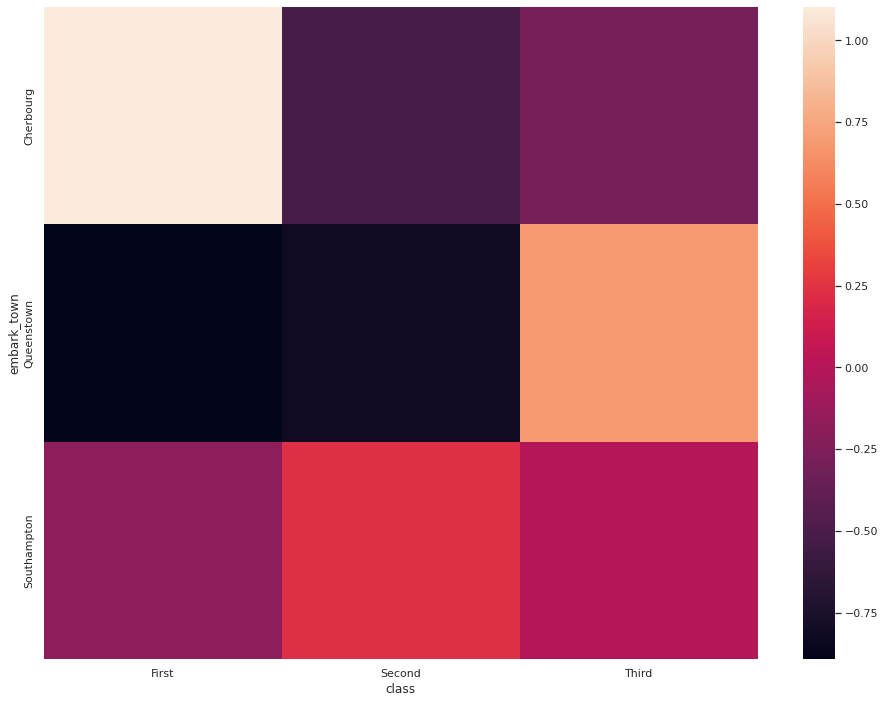

In [5]:
sns.heatmap(
    pd.DataFrame((contingency_table-exp)/exp, index=contingency_table.index, columns=contingency_table.columns)
)

There seems to be much more people from first class that have embarked in Cherbourg, and the lower classes are more represented from Queenstown.
The population from southampton only sees a positive deviation in second class.

To demonstrate that there can also be no correlation we now calculate the proportions of survival for each town and class combination.

In [6]:
survived_df = titanic_df.groupby(['embark_town', 'class']).survived.sum().unstack('class')/contingency_table
survived_df

class,First,Second,Third
embark_town,,,
Cherbourg,0.694118,0.529412,0.378788
Queenstown,0.500000,0.666667,0.375000
Southampton,0.582677,0.463415,0.189802


If we would do a Cramer V test now, we assume there would be no significance, as it would not make sense that the embarked town has no influence on the chances (proportion of survived persons) of survival.

In [7]:
chi, p, dof, exp = stats.chi2_contingency(survived_df, correction=True)
p

0.9989353452702686

As you can see, the p value is 0.99, indicating that the differences in embarkment are purely coincidental!

### Categorical vs continuous

The most interesting exploration (in my opinion) happens when we combine categorical and continuous data, as more graphing opportunities are present.
When doing this comparison, we usually use the student t-test or Z-test, you can spend hours arguing the difference and which to use, yet I will stick for simplicity with the t-test for robuustness.

we can use the t-test to check if a continuous variable changes between 2 categories of a categorical variable.


let us seperate the men from the women and see if they had to pay a different fare amount

In [8]:
t, p = stats.ttest_ind(
    titanic_df.fare[titanic_df.who=='man'],
    titanic_df.fare[titanic_df.who=='woman']
)
t, p

(-5.817465335062089, 8.614583735152227e-09)

Our p-value again is very low, indicating there is a difference in the groups.
The t statistic is -5.82, meaning that the second group (women) are paying more for fares.

We print out the means to verify

In [9]:
print('mean male fare')
print(titanic_df.fare[titanic_df.who=='man'].mean())
print('mean female fare')
print(titanic_df.fare[titanic_df.who=='woman'].mean())

mean male fare
24.864181750465548
mean female fare
46.570711070110704


By the looks of this, the fares are heavily gender biased.
To put this into more detail, we pivot the means of each group including class into a table, as female might be more in the upper classes.

In [10]:
titanic_df.groupby(['who', 'class']).fare.mean().unstack('class')

class,First,Second,Third
who,,,
child,139.382633,28.323905,23.220190
man,65.951086,19.054124,11.340213
woman,104.317995,20.868624,15.354351


This already makes more sense, it is mainly the first class difference that drives up the prices, yet the difference seems to be still present.

Can you perform a t-test on the gender fare gap in the third class, is it still significant?

A t-test is ideal if you would like to compare 2 groups, yet often we have multiple groups.
For this we can use a (one_way) ANOVA or ANalysis Of VAriance.

We seperate on class and check if the fare is significantly different.

In [11]:
F, p = stats.f_oneway(
    titanic_df.fare[titanic_df.pclass==1],
    titanic_df.fare[titanic_df.pclass==2],
    titanic_df.fare[titanic_df.pclass==3]
)
F, p

(242.34415651744814, 1.0313763209141171e-84)

This was more or less a no-brainer, as it is advertised that higher classes come with a higher pricetag.
We can use a nice histogram to show this division of class.

<AxesSubplot:xlabel='fare', ylabel='Count'>

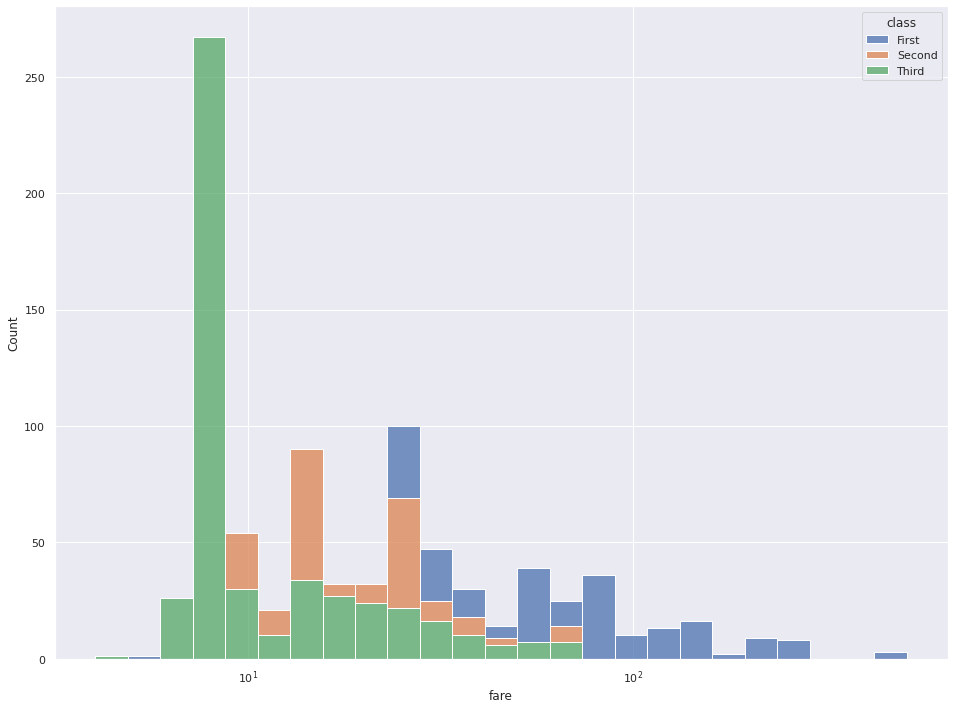

In [12]:
sns.histplot(data=titanic_df[titanic_df.fare!=0], x='fare', hue='class', log_scale=True, multiple='stack', bins=25)

A less cluttered plot would be to use a boxplot, containing less information about the distribution, yet still showing simple statistics.

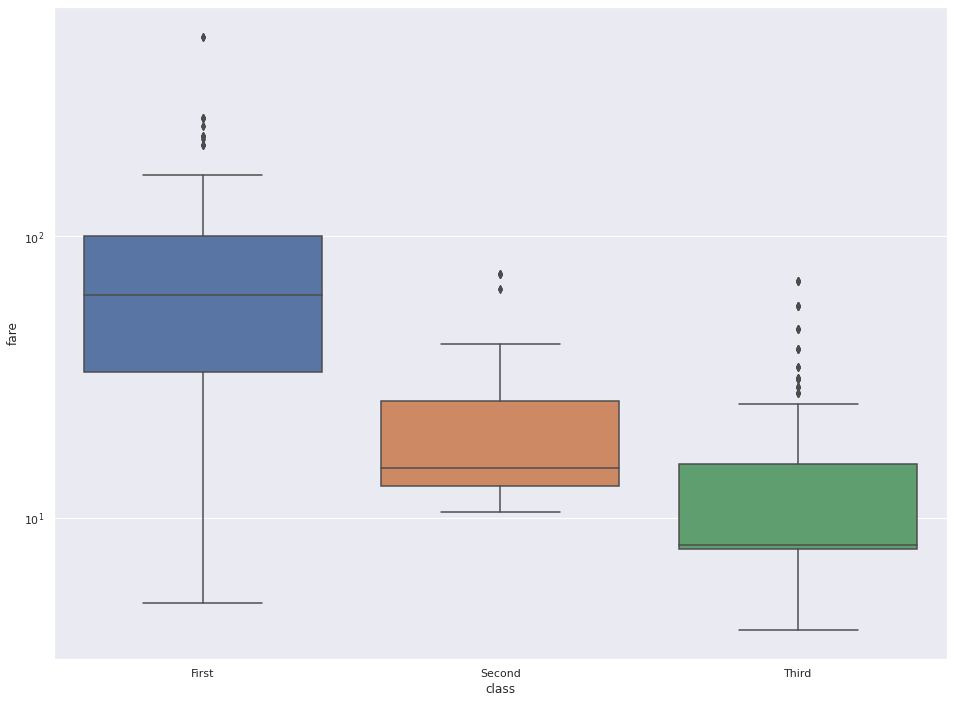

In [13]:
ax = sns.boxplot(data=titanic_df[titanic_df.fare!=0], x='class', y='fare')
ax.set_yscale("log")

We could do something similar, but taking the age instead of the fare, giving us the following result.

In [14]:
F, p = stats.f_oneway(
    titanic_df.age[titanic_df.pclass==1].dropna(),
    titanic_df.age[titanic_df.pclass==2].dropna(),
    titanic_df.age[titanic_df.pclass==3].dropna()
)
F, p

(57.443484340676214, 7.487984171959904e-24)

The p value indicates there is surely a difference in age between classes, how about we look at the means for each class.

In [15]:
titanic_df.groupby('pclass').age.mean()

pclass
1    38.233441
2    29.877630
3    25.140620
Name: age, dtype: float64

What about any statistical significant differences in ages for the groups that survived and didn't, could you perform this analysis?
Report your findings in a histogram.

### Continuous vs continuous

A thirds option to explore the interactions within your dataset is by comparing 2 continuous variables.

Seaborn has a nice functionality where can perform a jointplot that not only shows us the scatter plot but also the distributions, 
When we perform this plot we notice the inbalanced distribution of the fares.

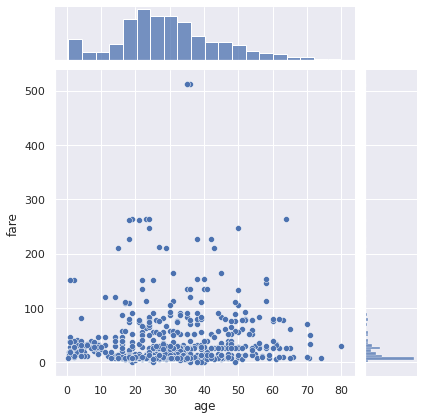

In [16]:
sns.jointplot(data=titanic_df, x='age', y='fare')

What we could do is remove outliers, if I recall correclty we set a upper bound of 77.5, let's do that here and replot.
I've also added the type of person as a color, you can here see that women and children pay more as we saw earlier.

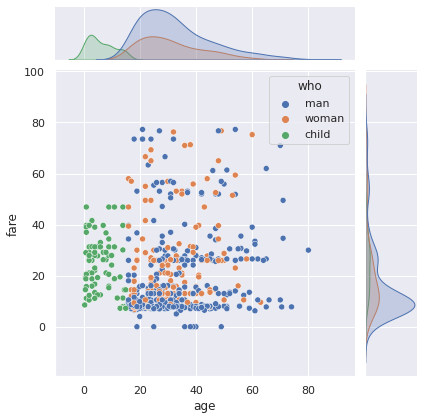

In [17]:
sns.jointplot(data=titanic_df[titanic_df.fare<77.5], x='age', y='fare', hue='who')

To make this more mathematically sound, we are using the spearman rank correlation test, not the pearson as we are dealing with non normal data. You could check that with a shapiro wilk test but i'll leave that up to you!

In [18]:
corr, p = stats.spearmanr(a=titanic_df[['age','fare']].dropna())
corr, p

(0.1350512177342878, 0.00029580903243060916)

with a p-value of only 0.000296 we can safely reject the null-hypothesis, meaning there is a correlation.
The correlation coefficient here is only 0.135, meaning for any person each year of age would make their fare about 0.135 dollars more expensive on average, which in that time was a fair amount of money.

To make this more visual, I added a lmplot that performs a linear regression, you can see how the line goes up in fare as the age goes up.
I had to use a logarithmic y-scale as the distribution is still not normal.

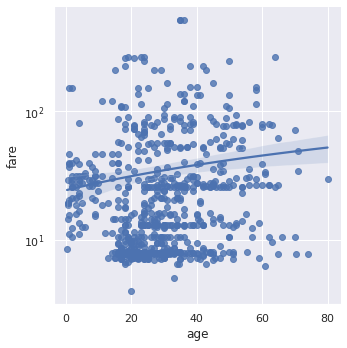

In [19]:
ax = sns.lmplot(data=titanic_df, x='age', y='fare')
ax.set(yscale='log')

Now this correlation of 0.135 dollar is relevant for ANY person, man, female, child, first class, second,...

Perhaps we could find several subgroups with a higher or lower correlation, I will perform the correlation with the outliers removed.

In [20]:
corr, p = stats.spearmanr(a=titanic_df[titanic_df.fare<77.5][['age','fare']].dropna())
corr, p

(0.09269934275477329, 0.019762193968013368)

When we remove outliers, we have a less strong correlations, indicating that the outliers - with high fares - are in general older persons.

Try to experiment with subsetting the data and find a group where age matters more for the correlation.